In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, RocCurveDisplay, precision_score,
                             recall_score, f1_score, accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import average_precision_score, precision_recall_curve

In [3]:
# Load data
seed=42
def load_data(path, clean_train=True):
    df = pd.read_csv(path)
    scaler = StandardScaler()
    features = df.columns.difference(['Class'])  # or use df.drop(columns=['Class']).columns
    df[features] = scaler.fit_transform(df[features])
    clean = df[df.Class == 0].copy().reset_index(drop=True)
    fraud = df[df.Class == 1].copy().reset_index(drop=True)
    print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

    if clean_train:
        train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
        print(f'Train Samples: {len(train)}')

        test = pd.concat([test_clean, fraud]).reset_index(drop=True)

        print(f'Test Samples: {len(test)}')

        # shuffle the test data
        test.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        train_X, train_y = train.loc[:, ~train.columns.isin(['Class'])], train.loc[:, train.columns.isin(['Class'])]
        test_X, test_y = test.loc[:, ~test.columns.isin(['Class'])], test.loc[:, test.columns.isin(['Class'])]
    else:
        clean_train, clean_test = train_test_split(clean, test_size=int(len(fraud)+(len(fraud)*0.9)), random_state=seed)
        fraud_train, fraud_test = train_test_split(fraud, test_size=int(len(fraud)*0.1), random_state=seed)
        
        train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
        test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)
        
        # shuffle
        train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Train Samples: {len(train_samples)}')
        test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Test Samples: {len(test_samples)}')
        train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['Class'])], train_samples.loc[:, train_samples.columns.isin(['Class'])]
        test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['Class'])], test_samples.loc[:, test_samples.columns.isin(['Class'])]
    
    return train_X, train_y, test_X, test_y

In [4]:
# Model training and evaluation
def train_evaluate_model(model, X_train, X_test, y_test):
    # Train model
    model.fit(X_train)

    if hasattr(model, 'decision_function'):
        scores = model.decision_function(X_test)
    else:  # For LOF
        scores = model.score_samples(X_test)
    scores = -scores

    # Predict anomalies (-1 for outliers, 1 for inliers)
    y_pred = model.predict(X_test)
    
    # Convert predictions to 0-1 (fraud=1, normal=0)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    # Calculate metrics
    metrics = {
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred)
    }
    
    return metrics, y_pred, scores

In [5]:
# Visualization functions
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(y_true, y_pred, model_name):
    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.title(f'{model_name} ROC Curve')
    plt.show()

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283823
Test Samples: 984


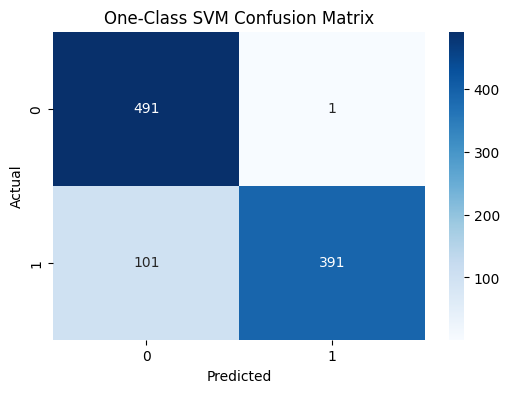

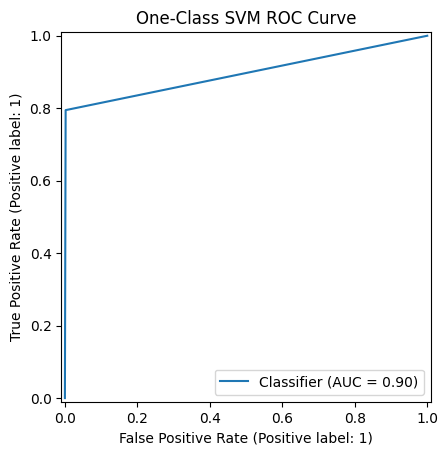


One-Class SVM Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       492
           1       1.00      0.79      0.88       492

    accuracy                           0.90       984
   macro avg       0.91      0.90      0.90       984
weighted avg       0.91      0.90      0.90       984



In [6]:
if __name__ == "__main__":
    X_train, y_train, X_test, y_test = load_data('creditcard.csv')
    models = {
        'One-Class SVM': OneClassSVM(
            kernel='rbf', 
            nu=0.002,  # Expected outlier proportion
            gamma='scale'
        )
    }
    
    # Train and evaluate models
    results = {}
    for name, model in models.items():
        metrics, y_pred, scores = train_evaluate_model(model, X_train, X_test, y_test)
        results[name] = metrics
        
        # Generate visualizations
        plot_confusion_matrix(y_test, y_pred, name)
        plot_roc_curve(y_test, y_pred, name)
        
        print(f'\n{name} Classification Report:')
        print(classification_report(y_test, y_pred))

In [7]:
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1_Score:", metrics['f1'])
print("Accuracy:", metrics['accuracy'] )

Precision: 0.9974489795918368
Recall: 0.7947154471544715
F1_Score: 0.8846153846153846
Accuracy: 0.8963414634146342
